# Relationships Between FDG and Plasma Biomarkers in the Riluzole dataset

In [1]:
# install required packages - commented out so it doesn't install every time
#%conda install -n Lauren openpyxl numpy pandas statsmodels plotnine matplotlib scikit-learn scipy mizani nbconvert pandoc pyreadstat kmodes seaborn

# import required packages
import numpy as np;
import pandas as pd;
import plotnine as p9;
import pickle

import warnings
warnings.filterwarnings( "ignore", module = "plotnine\..*" ) # only include this once finished and want to create nicer figures for pdf


# read in and clean data

In [2]:
data_folder_loc = '//admsyn/Primary/ADM/CustomerStudies/Rockefeller/Riluzole_Biomarkers/'
code_folder_loc = '//admsyn/homes/@DH-ADMDX/0/lauren.koenig-1606/code/Riluzole FDG/'

biomarker_relationship_results_log10, biomarker_relationship_results_raw, all_data = pd.read_pickle(code_folder_loc + '/output/04_data_new_para_rr.pkl')
all_data = all_data[all_data['timepoint'].isin(['base']) & all_data['age'].notna() & all_data['Education_years'].notna()]

all_data = all_data.rename(columns = {'race':'race_ethnicity'})

In [3]:
biomarker_relationship_results_log10['mv_ageedu_n'].astype('float64').round(2).describe()

count    963.000000
mean      33.386293
std        3.497891
min       16.000000
25%       30.000000
50%       34.000000
75%       36.000000
max       41.000000
Name: mv_ageedu_n, dtype: float64

In [4]:
# define biomarker groups
FDG_columns = ['MTL_gm', 'SensMot_gm', 'FRONTAL_gm', 'AC_gm', 'Precun_gm', 'Par_gm', 'Temp_gm', 'Paracentral_gm', 'PostCing_gm']

plasma_columns = ['Ab42_40', 'GFAP','NFL',  'pTau181', 'pTau217',  'pTau231']
log10_plasma_columns = [s + '_log10' for s in plasma_columns]

cog_columns = ['MMSE', 'adascogtotal', 'bvrt', 'dstotal','tma','tmb',  'cowattotal', 'cdrtotal', 'cdrsum', 'adltotal', 'npitotal', 'gds']
vol_columns = ['VOL_Precun_Lz', 'VOL_Precun_Rz', 'VOL_InfPar_Lz', 'VOL_InfPar_Rz', 'VOL_Hip_Lz', 'VOL_Hip_Rz', 'VOL_TotalGrayz',
 'VOL_Inf_Mid_Fus_Temp_Lz', 'VOL_Inf_Mid_Fus_Temp_Rz', 'VOL_MidFront_Rz', 'VOL_MidFront_Lz']

all_data['VOL_Hip_z'] = all_data[['VOL_Hip_Rz', 'VOL_Hip_Lz']].mean(axis = 1)

graphing_pval = 0.05
pvals_to_consider = ['mv_ageedu_p_baseline']
Bval_to_grab = 'mv_ageedu_B_baseline'


all_data['age_decade2'] = all_data['age_decade2'].astype('str').str.replace('nan', 'unknown')

all_data['MMSE_bin'] = pd.cut(all_data['MMSE'], [18, 20, 23, 27]).astype('str').str.replace('nan', 'unknown')
all_data['cdrsum_bin'] = pd.cut(all_data['cdrsum'], [0, 2.5, 3.5, 10]).astype('str').str.replace('nan', 'unknown')
all_data['Ab42_40_bin'] = pd.cut(all_data['Ab42_40'], [0.04, 0.06, 0.07,  0.11]).astype('str').str.replace('nan', 'unknown')
all_data['pTau217_bin'] = pd.cut(all_data['pTau217'], [0.2, 1.1, 2, 4.5]).astype('str').str.replace('nan',  'unknown')
all_data['GFAP_bin'] = pd.cut(all_data['GFAP'], [75, 175, 275, 475]).astype('str').str.replace('nan', 'unknown')
all_data['NFL_bin'] = pd.cut(all_data['NFL'], [15, 30, 45, 90]).astype('str').str.replace('nan', 'unknown')
all_data['VOL_Hip_z_bin'] = pd.cut(all_data['VOL_Hip_z'], [-5.4, -2.7, -1.2, 1.3]).astype('str').str.replace('nan', 'unknown')

In [5]:
def pval_rounder(pval):
    if (pval < 0.001):
        pval_str = 'p<0.001'
    elif (pval < 0.05) & (pval >= 0.04995):
        pval_str = 'p=' + pval.round(5).astype('str')
    elif (pval < 0.05) & (pval >= 0.0495):
        pval_str = 'p=' + pval.round(4).astype('str')
    elif (pval < 0.05) & (pval >= 0.045):
        pval_str = 'p=' + pval.round(3).astype('str')
    elif (pval < 0.01) & (pval > 0.001):
        pval_str = 'p=' + pval.round(3).astype('str')
    elif (pval >= 0.01):
        pval_str = 'p=' + pval.round(2).astype('str')
    return pval_str



def real_name(var):
    var_str = ''
    if (var == 'Ab40') : var_str = 'Plasma Amyloid-Beta 40' 
    elif (var == 'Ab42') : var_str = 'Plasma Amyloid-Beta 42' 
    elif (var == 'Ab42_40') : var_str = 'Plasma Amyloid-Beta 42/40' 
    elif (var == 'GFAP') : var_str = 'Plasma GFAP' 
    elif (var == 'NFL') : var_str = 'Plasma NFL' 
    elif (var == 'pTau181') : var_str = 'Plasma p-tau 181' 
    elif (var == 'pTau217') : var_str = 'Plasma p-tau 217' 
    elif (var == 'pTau231') : var_str = 'Plasma p-tau 231' 
    elif (var == 'MTL_gm') : var_str = 'Medial Temporal Lobe FDG' 
    elif (var == 'SensMot_gm') : var_str = 'Sensorimotor Cortex FDG' 
    elif (var == 'FRONTAL_gm') : var_str = 'Frontal Cortex FDG' 
    elif (var == 'AC_gm') : var_str = 'Anterior Cingulate Cortex FDG' 
    elif (var == 'Precun_gm') : var_str = 'Precuneus Cortex FDG' 
    elif (var == 'Par_gm') : var_str = 'Parietal Cortex FDG' 
    elif (var == 'Temp_gm') : var_str = 'Temporal Cortex FDG' 
    elif (var == 'Paracentral_gm') : var_str = 'Paracentral Cortex FDG' 
    elif (var == 'PostCing_gm') : var_str = 'Posterior cingulate Cortex FDG' 
    elif (var == 'adascogtotal') : var_str = 'Alzheimer\'s Disease Assessment Scale – Cognitive Subscale (ADAS‐cog)' 
    elif (var == 'bvrt') : var_str = 'Benton Visual Retention Test' 
    elif (var == 'dstotal') : var_str = 'Digit Span Test' 
    elif (var == 'tma') : var_str = 'Trails A Test' 
    elif (var == 'tmb') : var_str = 'Trails B Test' 
    elif (var == 'cowattotal') : var_str = 'Controlled Oral Word Association Test (COWAT)' 
    elif (var == 'cdrtotal') : var_str = 'Clinical Dementia Rating (CDR)' 
    elif (var == 'cdrsum') : var_str = 'CDR Sum of Boxes' 
    elif (var == 'adltotal') : var_str = 'ADCS Activities of Daily Living (ADL) Scale' 
    elif (var == 'npitotal') : var_str = 'Neuropsychiatric Inventory (NPI)' 
    elif (var == 'gds') : var_str = 'Geriatric Depression Scale' 
    elif (var == 'VOL_Precun_Lz') : var_str = 'Left Precuneus Volume z-score' 
    elif (var == 'VOL_Precun_Rz') : var_str = 'Right Precuneus Volume z-score' 
    elif (var == 'VOL_InfPar_Lz') : var_str = 'Left Inferior Parietal Volume z-score' 
    elif (var == 'VOL_InfPar_Rz') : var_str = 'Right Inferior Parietal Volume z-score' 
    elif (var == 'VOL_Hip_Lz') : var_str = 'Left Hippocampal Volume z-score' 
    elif (var == 'VOL_Hip_Rz') : var_str = 'Right Hippocampal Volume z-score' 
    elif (var == 'VOL_TotalGrayz') : var_str = 'Total Gray Matter Volume z-score' 
    elif (var == 'VOL_Inf_Mid_Fus_Temp_Lz') : var_str = 'Left Inferior Middle Fusiform and Temporal Cortex z-score' 
    elif (var == 'VOL_Inf_Mid_Fus_Temp_Rz') : var_str = 'Right Inferior Middle Fusiform and Temporal Cortex z-score' 
    elif (var == 'VOL_MidFront_Rz') : var_str = 'Right Middle Frontal Cortex z-score' 
    elif (var == 'VOL_MidFront_Lz') : var_str = 'Left Middle Frontal Cortex z-score' 
    elif (var == 'age') : var_str = 'Age' 
    elif (var == 'Education_years') : var_str = 'Years of Education' 
    elif (var == 'sex') : var_str = 'Sex' 
    elif (var == 'apoe4_carrier') : var_str = 'APOE E4 Carrier' 
    elif (var == 'race_ethnicity') : var_str = 'Race and Ethnicity' 
    elif (var == 'age_decade2') : var_str = 'Age Group' 
    elif (var == 'MMSE_bin') : var_str = 'MMSE Group' 
    elif (var == 'cdrsum_bin') : var_str = 'CDR Group' 
    elif (var == 'Ab42_40_bin') : var_str = 'Plasma Amyloid-Beta\n42/40 Group\n' 
    elif (var == 'pTau217_bin') : var_str = 'Plasma p-tau\n217 Group\n' 
    elif (var == 'GFAP_bin') : var_str = 'Plasma\nGFAP Group\n' 
    elif (var == 'NFL_bin') : var_str = 'Plasma\nNFL Group\n' 
    elif (var == 'VOL_Hip_z_bin') : var_str = 'Average\nHippocampal\nz-score Group\n\n' 
    return var_str

# Table 1 - Demographics

In [6]:
for var in ['age', 'Education_years']:
    print(var, '\n', all_data[var].describe()[['mean', 'std']].round(1), '\n\n')
for var in ['sex', 'race_ethnicity', 'apoe4_carrier']:
    print(var, '\n', all_data[var].value_counts().sort_index(), '\n',
     (all_data[var].value_counts(normalize=True).sort_index().mul(100).round().astype('int').astype(str) + '%'), '\n\n')


age 
 mean    74.6
std      6.8
Name: age, dtype: float64 


Education_years 
 mean    15.5
std      3.1
Name: Education_years, dtype: float64 


sex 
 sex
F    28
M    19
Name: count, dtype: int64 
 sex
F    60%
M    40%
Name: proportion, dtype: object 


race_ethnicity 
 race_ethnicity
Black        2
White/NH    39
Name: count, dtype: int64 
 race_ethnicity
Black        5%
White/NH    95%
Name: proportion, dtype: object 


apoe4_carrier 
 apoe4_carrier
No     17
Yes    23
Name: count, dtype: int64 
 apoe4_carrier
No     42%
Yes    57%
Name: proportion, dtype: object 




In [7]:
print('any missing covariate data?')
all_data[['age', 'Education_years', 'sex', 'race_ethnicity', 'apoe4_carrier']].isna().value_counts().sort_index()

any missing covariate data?


age    Education_years  sex    race_ethnicity  apoe4_carrier
False  False            False  False           False            40
                                               True              1
                               True            True              6
Name: count, dtype: int64

# Figure 1 - Ptau-217 results

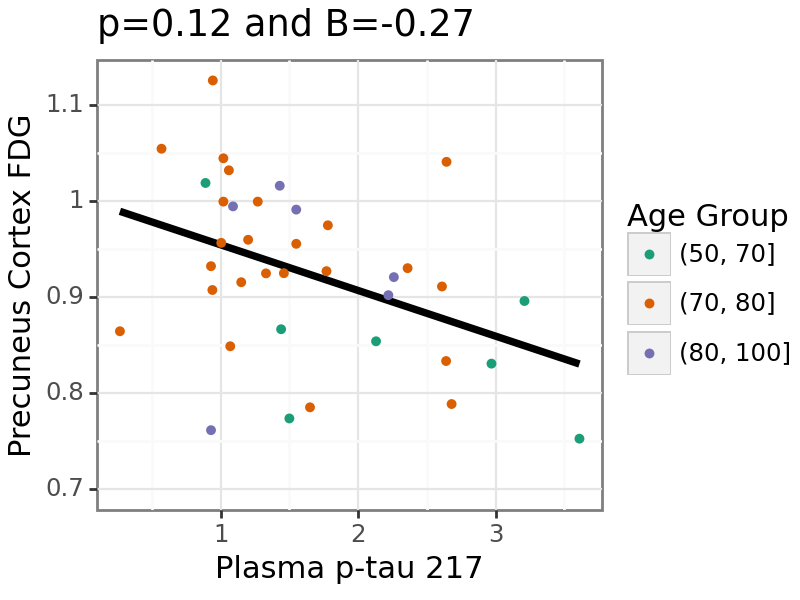

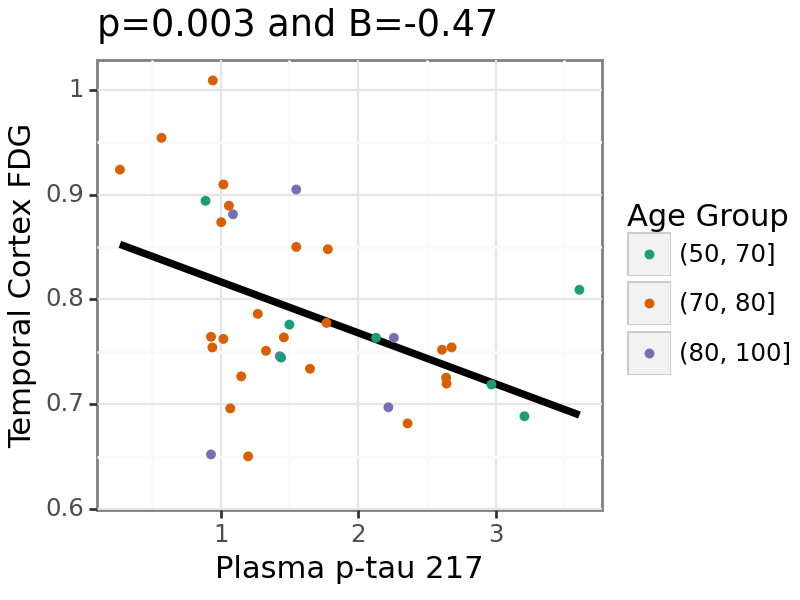

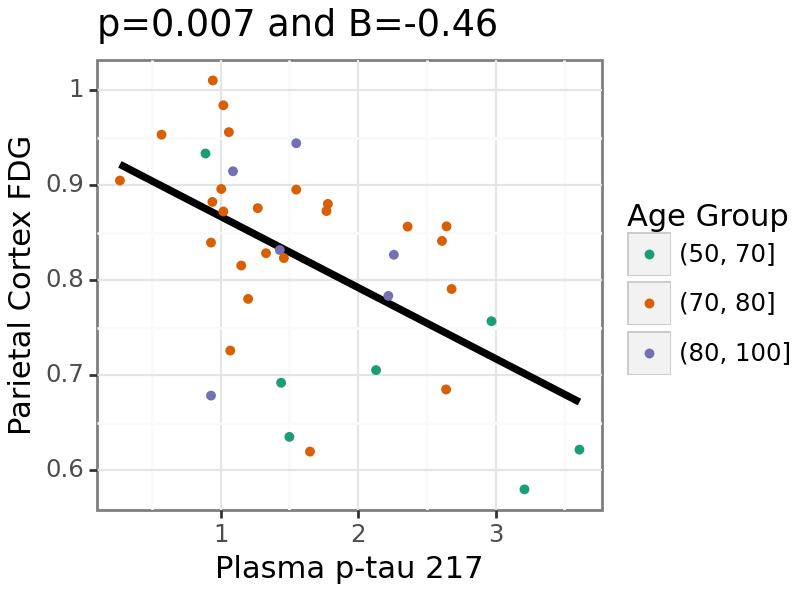

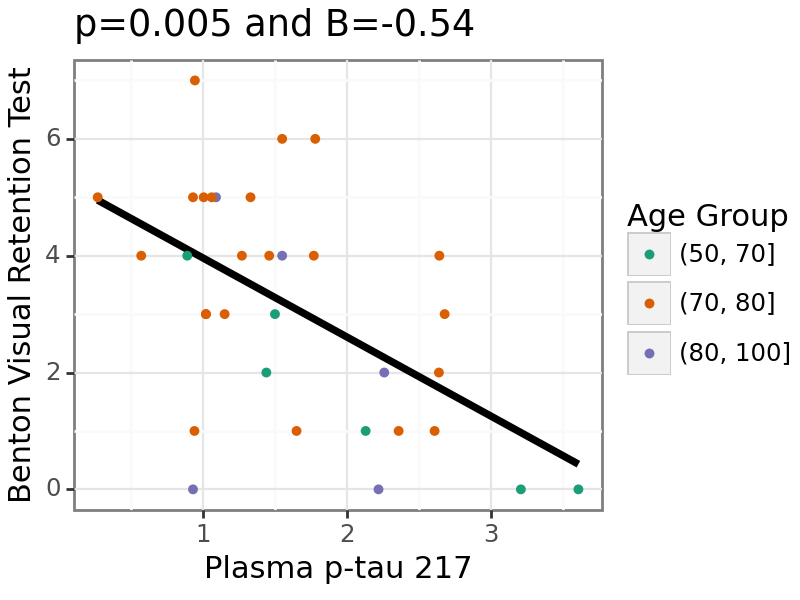

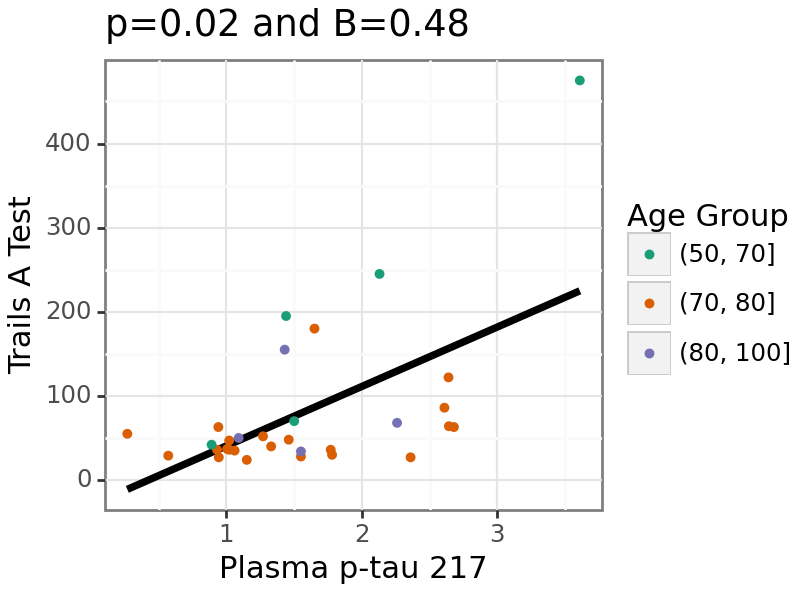

In [8]:
p9.options.figure_size = (4,3)    
color_group = 'age_decade2'

var1 = 'pTau217'
var2 = 'Precun_gm'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_1a =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value) + ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_1a)

var1 = 'pTau217'
var2 = 'Temp_gm'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_1b =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_1b)

var1 = 'pTau217'
var2 = 'Par_gm'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_1c =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_1c)

var1 = 'pTau217'
var2 = 'bvrt'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_1d =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_1d)

var1 = 'pTau217'
var2 = 'tma'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_1e =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value) + ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_1e)

# Figure 3 - GFAP Results

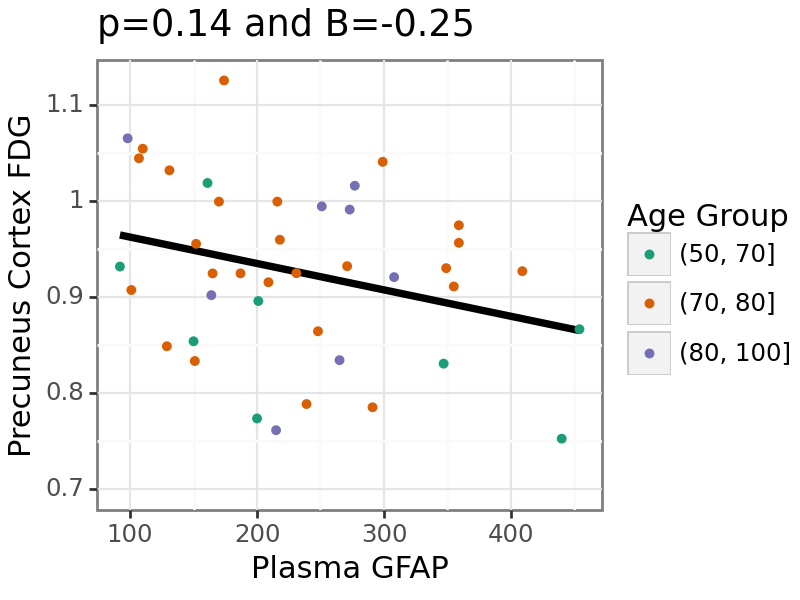

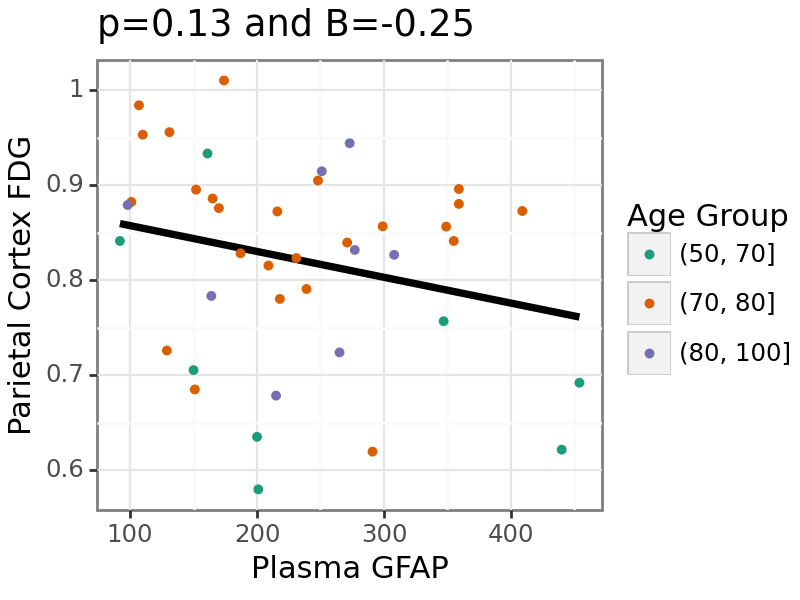

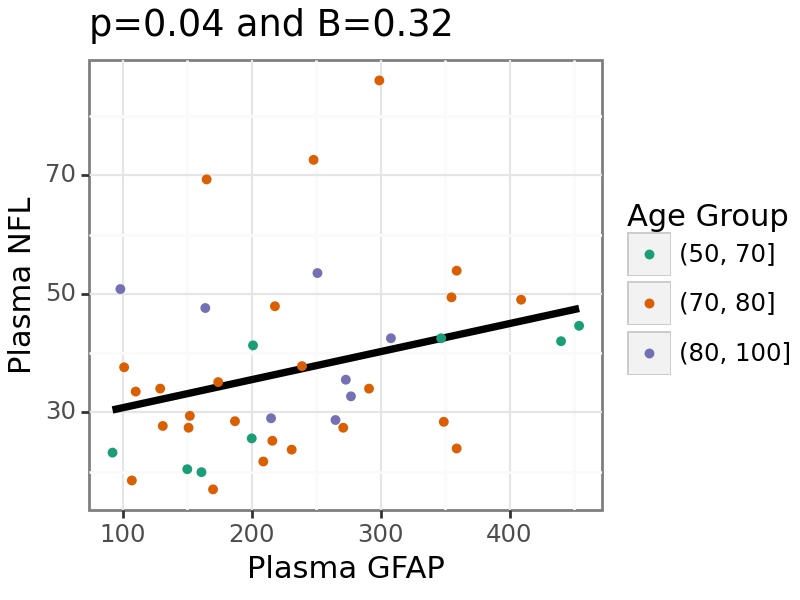

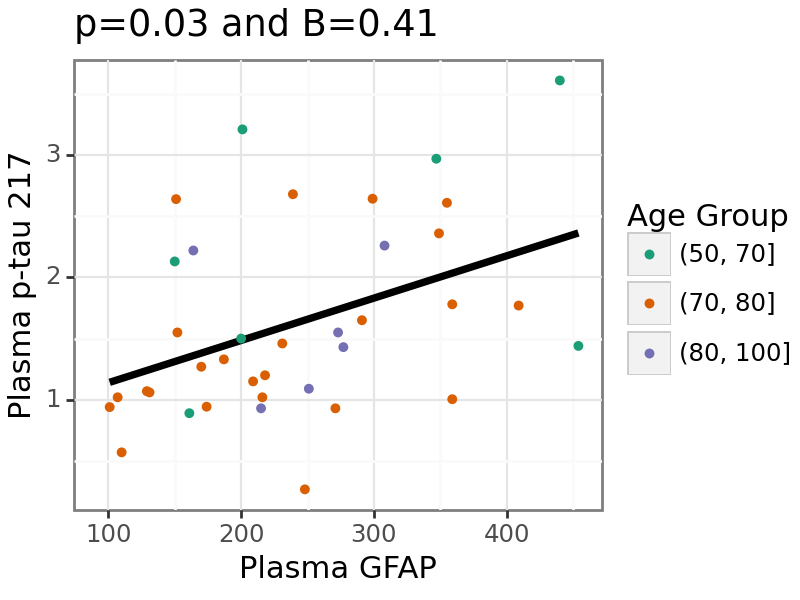

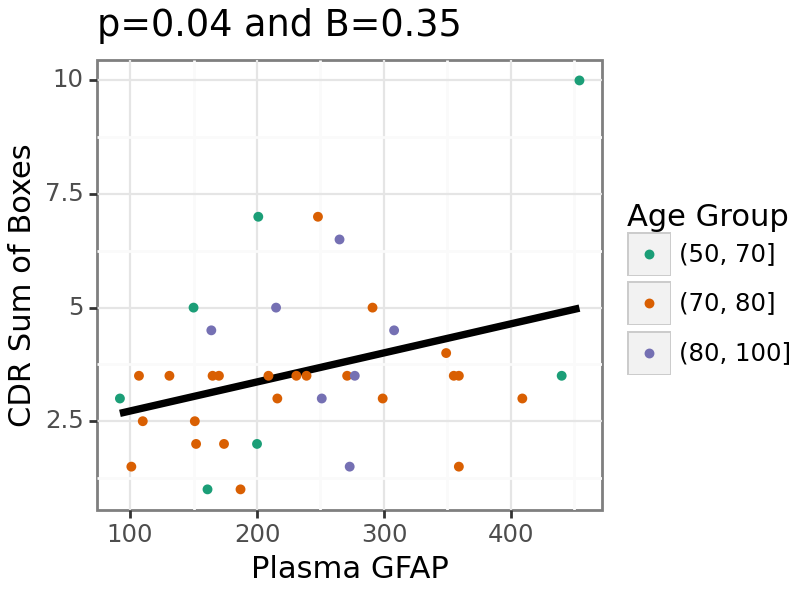

In [9]:
var1 = 'GFAP'
var2 = 'Precun_gm'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_2a =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_2a)

var1 = 'GFAP'
var2 = 'Par_gm'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_2b =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_2b)

var1 = 'GFAP'
var2 = 'NFL'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_2c =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_2c)

var1 = 'GFAP'
var2 = 'pTau217'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_2d =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_2d)

var1 = 'GFAP'
var2 = 'cdrsum'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_2e =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_2e)

# Figure 4 - Ptau Comparisons

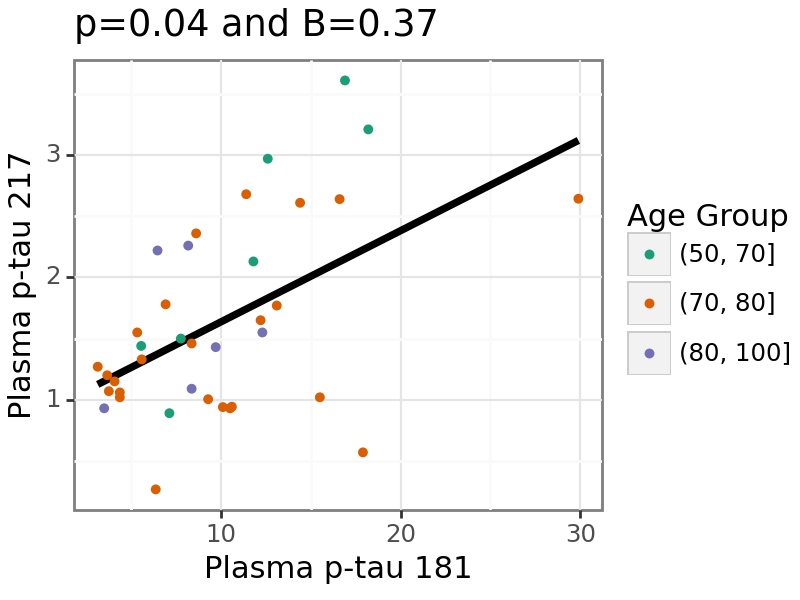

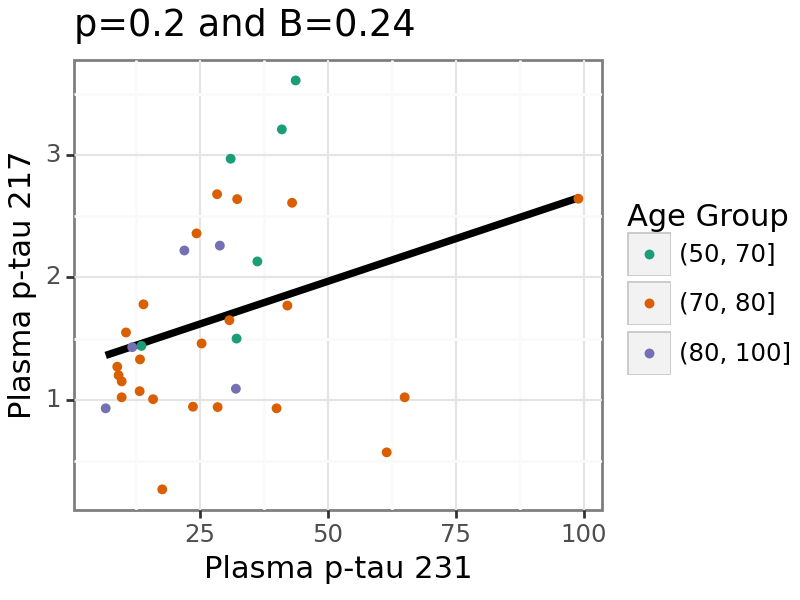

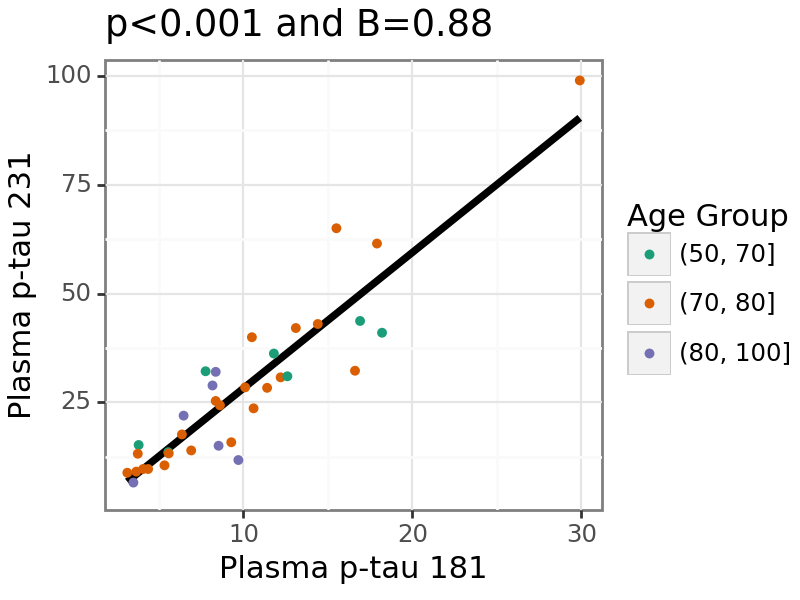

In [10]:
var1 = 'pTau181'
var2 = 'pTau217'


p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_3a =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')           
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_3a)


var1 = 'pTau231'
var2 = 'pTau217'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_3b =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')            
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_3b)


var1 = 'pTau181'
var2 = 'pTau231'
p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
fig_3c =  (
            p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')            
            + p9.geom_point(size = 1.0)
            + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
            + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
        )
print(fig_3c)

# Possible Supplemental Figures

## pTau181 vs FDG MTL and pTau231 vs FDG MTL - split into subgroups

### Original / No Subgroups

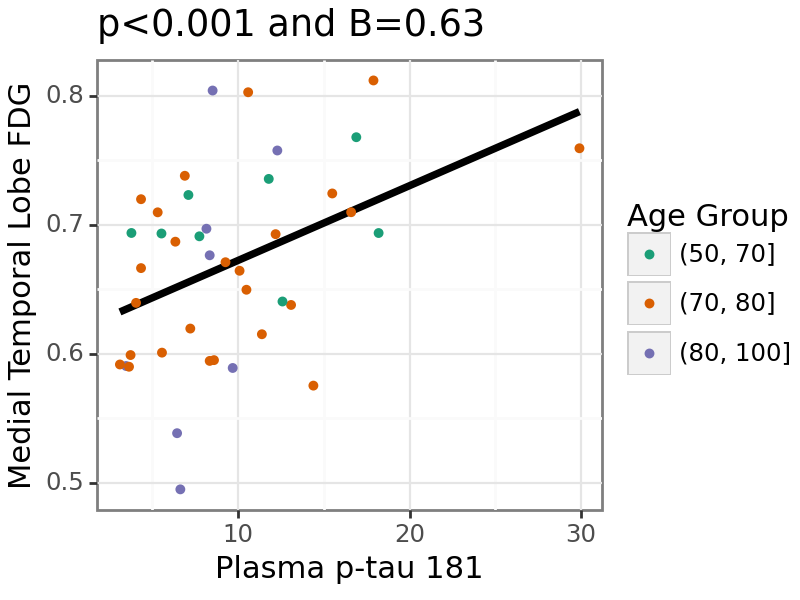

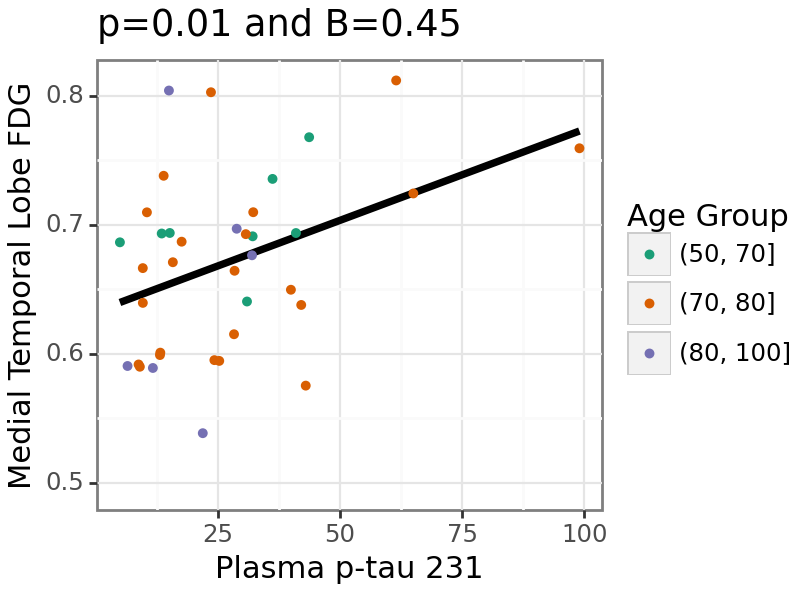

In [11]:
p9.options.figure_size = (4,3)  

for var2 in[ele for ele in ['Avg_Hip', 'MTL_gm'] if ele in all_data.columns]:
    for var1 in ['pTau181', 'pTau231']:
        p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
        B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
        plot = (
                p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
                + p9.theme_bw(base_size = 11)
                + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')                
                + p9.geom_point(size = 1.0)
                + p9.labs(title = (pval_rounder(p_value) + ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
                + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
            )
        print(plot)

### age

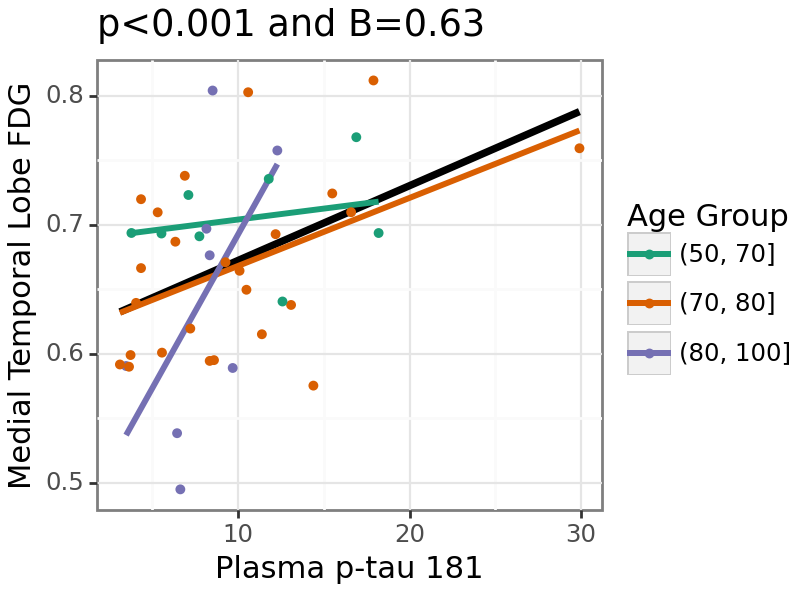

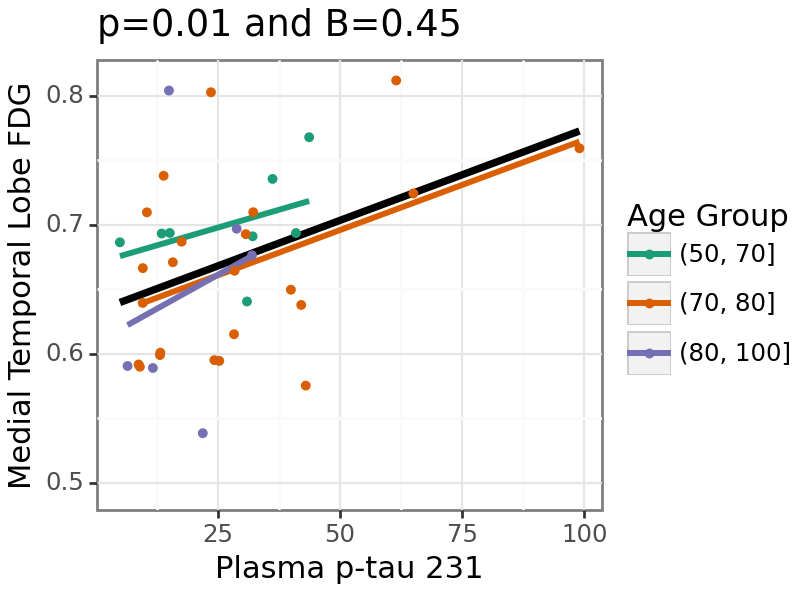

In [12]:
p9.options.figure_size = (4,3)  
color_group = 'age_decade2'

for var2 in[ele for ele in ['Avg_Hip', 'MTL_gm'] if ele in all_data.columns]:
    for var1 in ['pTau181', 'pTau231']:
        p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
        B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
        plot = (
                p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
                + p9.theme_bw(base_size = 11)
                + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')
                + p9.geom_smooth(size = 1.2, se = False, alpha = 1, method = 'lm')
                + p9.geom_point(size = 1.0)
                + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
                + p9.scale_color_manual(['#1b9e77', '#d95f02', '#7570b3', '#737373'])
            )
        print(plot)

### CDR sum of boxes

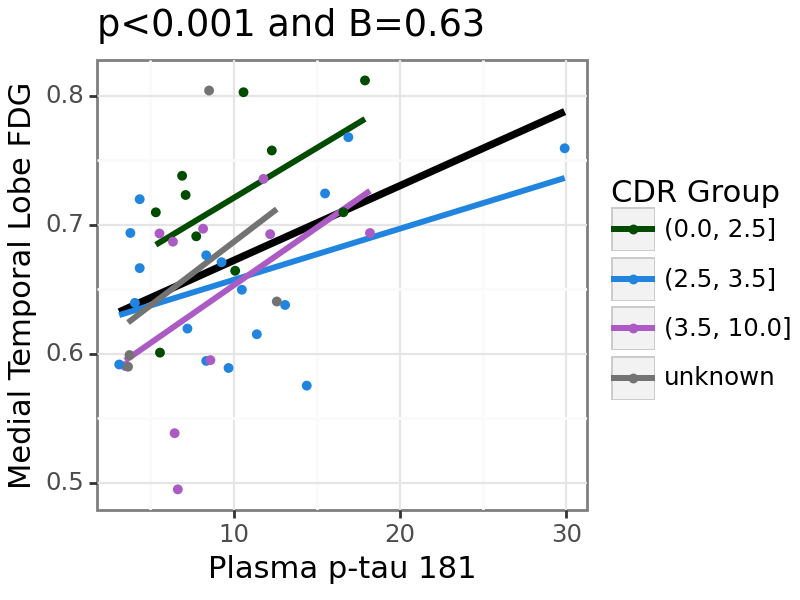

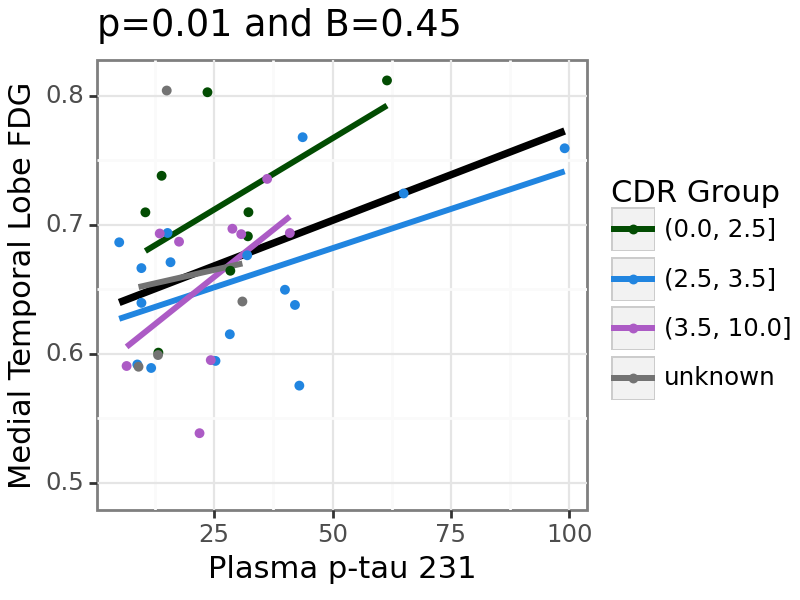

In [13]:
p9.options.figure_size = (4,3)  
color_group = 'cdrsum_bin'

for var2 in [ele for ele in ['Avg_Hip', 'MTL_gm'] if ele in all_data.columns]:
    for var1 in ['pTau181', 'pTau231']:
        p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
        B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
        plot = (
                p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
                + p9.theme_bw(base_size = 11)
                + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')
                + p9.geom_smooth(size = 1.2, se = False, alpha = 1, method = 'lm')
                + p9.geom_point(size = 1.0)
                + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
                + p9.scale_color_manual(['#024c02', '#2185e0', '#ac5bc5' , '#737373'])
            )
        print(plot)

### Ab42/40 

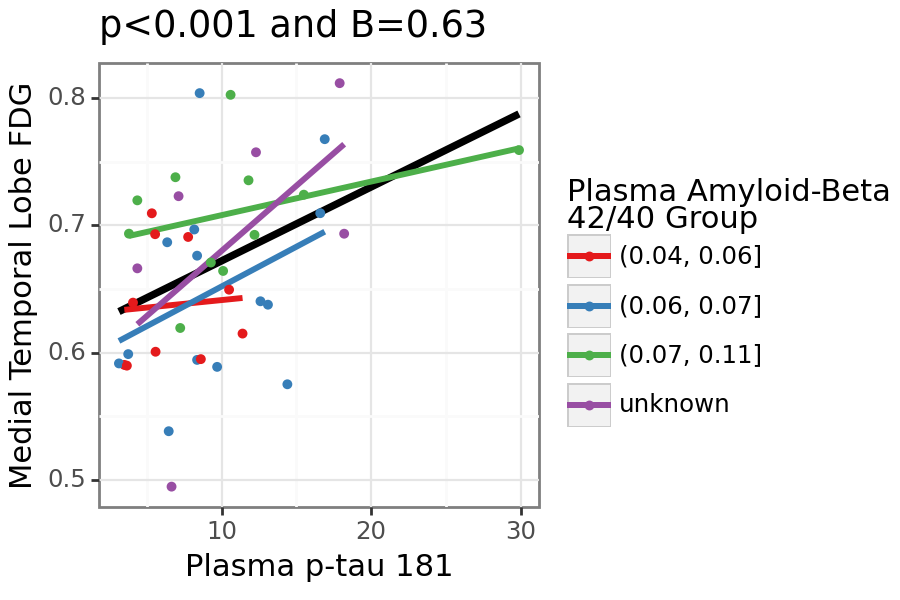

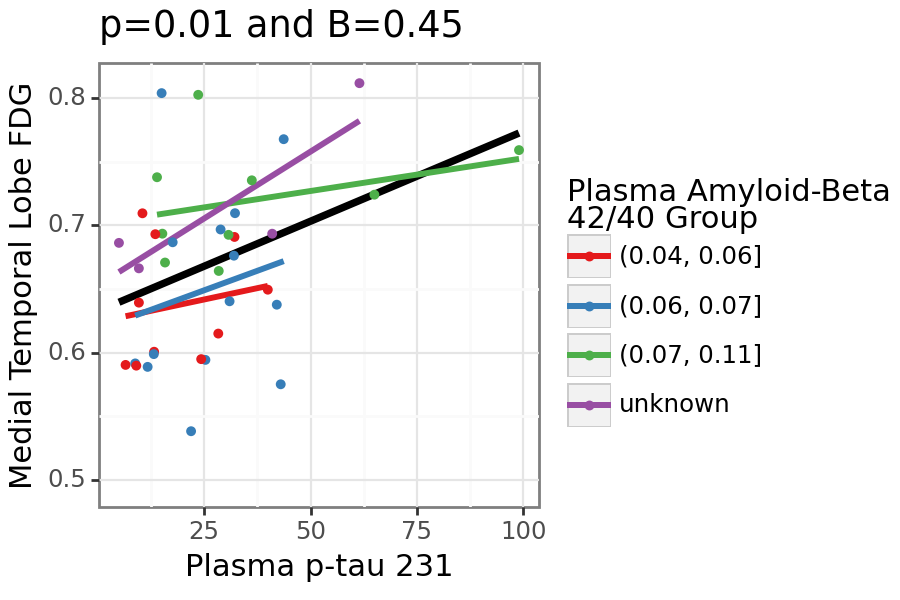

In [14]:
p9.options.figure_size = (4.5,3)  
color_group = 'Ab42_40_bin'

for var2 in[ele for ele in ['Avg_Hip', 'MTL_gm'] if ele in all_data.columns]:
    for var1 in ['pTau181', 'pTau231']:

        p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
        B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
        plot = (
                p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
                + p9.theme_bw(base_size = 11)
                + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')
                + p9.geom_smooth(size = 1.2, se = False, alpha = 1, method = 'lm')
                + p9.geom_point(size = 1.0)
                + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
                + p9.scale_color_brewer(type='qual', palette='Set1')
            )
        print(plot)

### pTau217

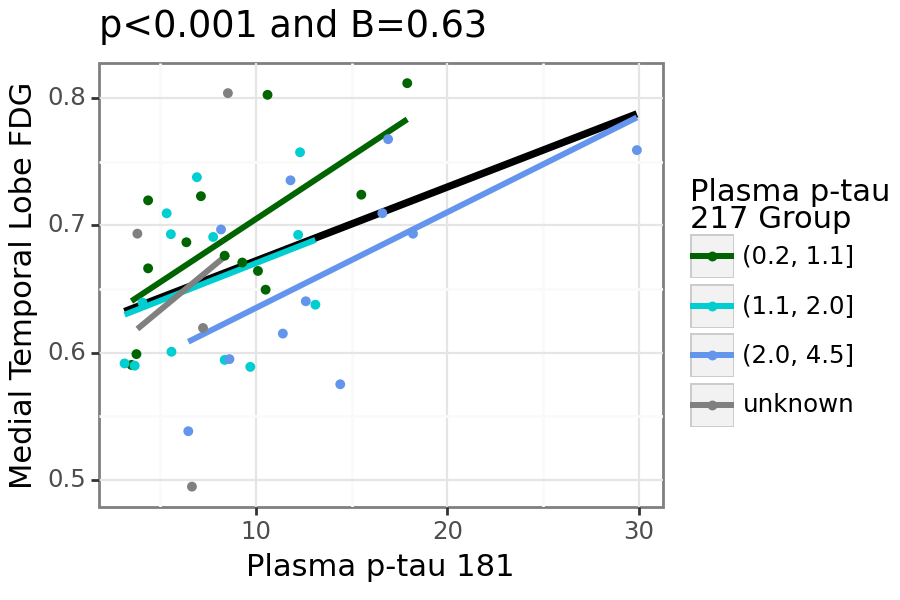

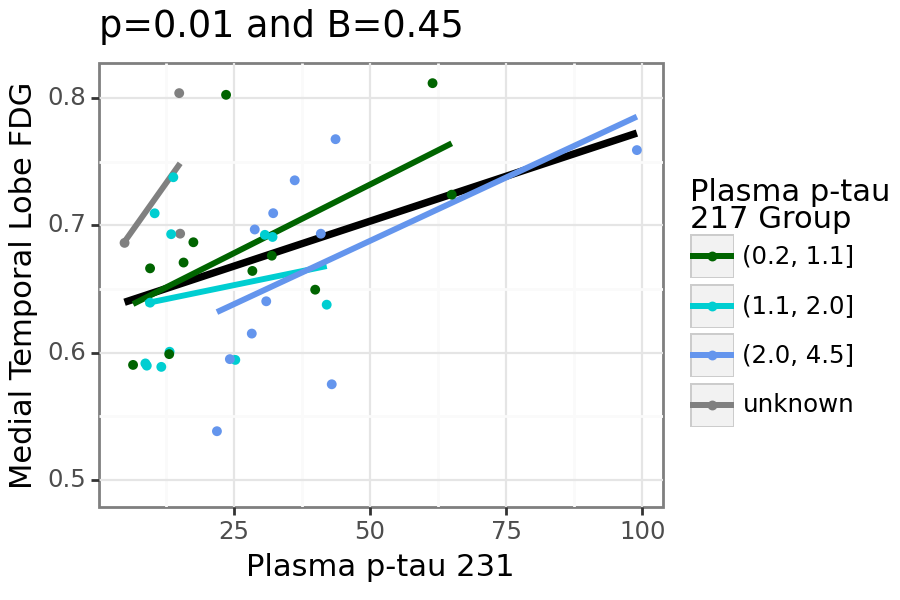

In [15]:
p9.options.figure_size = (4.5,3)  
color_group = 'pTau217_bin'

for var2 in[ele for ele in ['Avg_Hip', 'MTL_gm'] if ele in all_data.columns]:
    for var1 in ['pTau181', 'pTau231']:
        p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
        B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
        plot = (
                p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
                + p9.theme_bw(base_size = 11)
                + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')
                + p9.geom_smooth(size = 1.2, se = False, alpha = 1, method = 'lm')
                + p9.geom_point(size = 1.0)
                + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
                + p9.scale_color_manual(['darkgreen', 'darkturquoise', 'cornflowerblue', 'grey'])
            )
        print(plot)

### GFAP

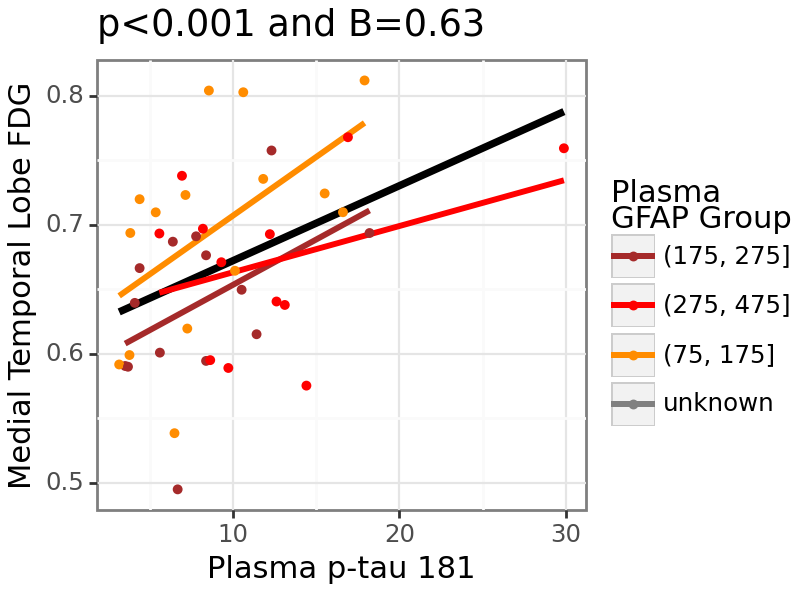

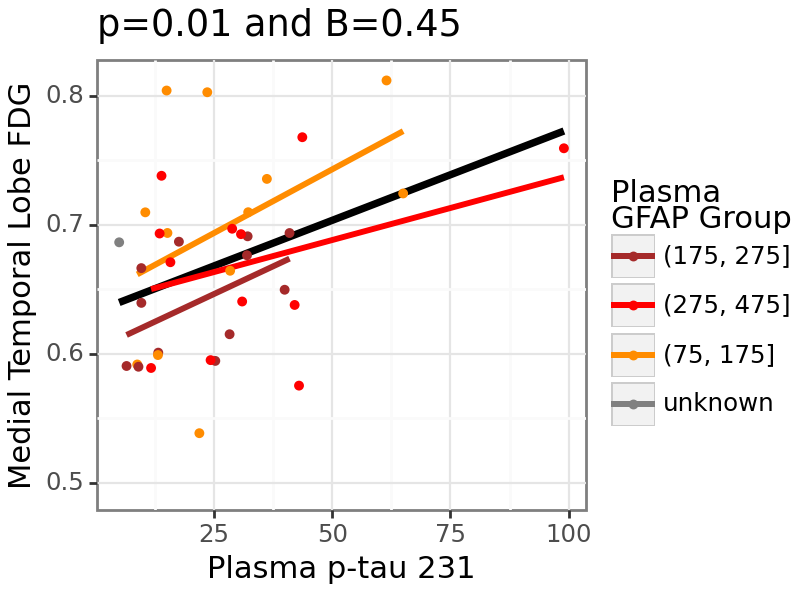

In [16]:
p9.options.figure_size = (4,3)  
color_group = 'GFAP_bin'

for var2 in[ele for ele in ['Avg_Hip', 'MTL_gm'] if ele in all_data.columns]:
    for var1 in ['pTau181', 'pTau231']:
        p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
        B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
        plot = (
                p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
                + p9.theme_bw(base_size = 11)
                + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')
                + p9.geom_smooth(size = 1.2, se = False, alpha = 1, method = 'lm')
                + p9.geom_point(size = 1.0)
                + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
                + p9.scale_color_manual(['brown', 'red', 'darkorange', 'grey'])
            )
        print(plot)

### NFL

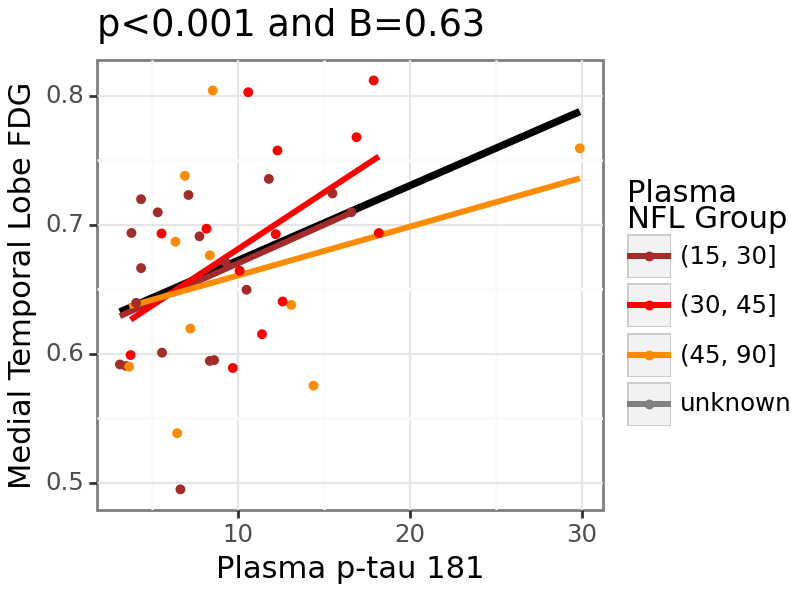

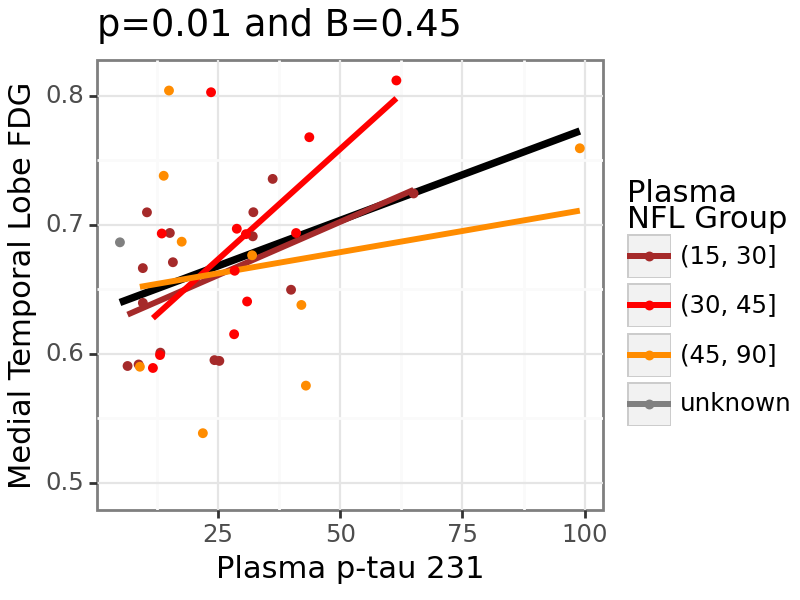

In [17]:
p9.options.figure_size = (4,3)  
color_group = 'NFL_bin'

for var2 in[ele for ele in ['Avg_Hip', 'MTL_gm'] if ele in all_data.columns]:
    for var1 in ['pTau181', 'pTau231']:
        p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
        B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
        plot = (
                p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
                + p9.theme_bw(base_size = 11)
                + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')
                + p9.geom_smooth(size = 1.2, se = False, alpha = 1, method = 'lm')
                + p9.geom_point(size = 1.0)
                + p9.labs(title = (pval_rounder(p_value)+ ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
                + p9.scale_color_manual(['brown', 'red', 'darkorange', 'grey'])
            )
        print(plot)

### Hippocampal Volume

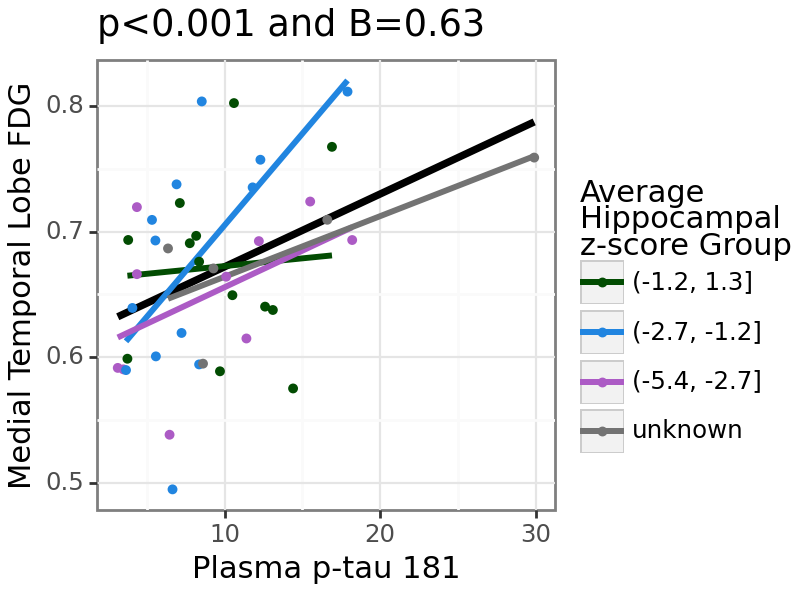

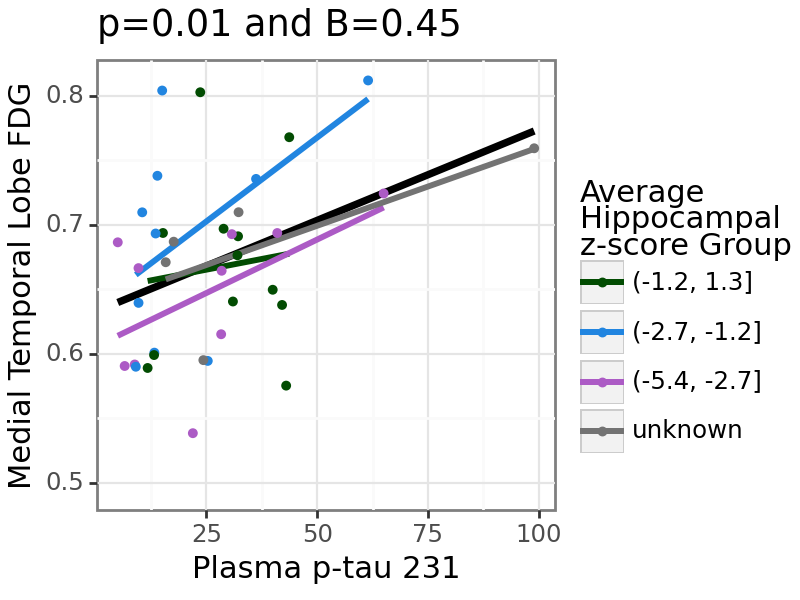

In [18]:
p9.options.figure_size = (4,3)  
color_group = 'VOL_Hip_z_bin'

for var2 in[ele for ele in ['Avg_Hip', 'MTL_gm'] if ele in all_data.columns]:
    for var1 in ['pTau181', 'pTau231']:
        p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), pvals_to_consider[0]].reset_index(drop=True)[0]
        B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['var1'].isin([var1]) & biomarker_relationship_results_log10['var2'].isin([var2]), Bval_to_grab].reset_index(drop=True)[0].round(2).astype('str')
        plot = (
                p9.ggplot(all_data, p9.aes(x = var1, y = var2, color = color_group))
                + p9.theme_bw(base_size = 11)
                + p9.geom_smooth(size = 1.5, se = False, alpha = 1, color = 'black', method = 'lm')
                + p9.geom_smooth(size = 1.2, se = False, alpha = 1, method = 'lm')
                + p9.geom_point(size = 1.0)
                + p9.labs(title = (pval_rounder(p_value) + ' and B=' + B_value), x=real_name(var1), y=real_name(var2), color=real_name(color_group))
                + p9.scale_color_manual(['#024c02', '#2185e0', '#ac5bc5' , '#737373'])
            )
        print(plot)